<a href="https://colab.research.google.com/github/iongie/demo-day-fin-8/blob/main/_Demo_day_Fintech_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo day Fintech 8

"Data tersebut terkait dengan kampanye pemasaran langsung dari lembaga perbankan Portugis. Kampanye pemasaran didasarkan pada panggilan telepon. Seringkali, lebih dari satu kontak ke klien yang sama diperlukan, untuk mengakses apakah produk (deposito berjangka bank) akan ('ya') atau tidak ('tidak') dilanggan oleh pelanggan atau tidak. Folder data berisi dua kumpulan data: -

     train.csv: 45.211 baris dan 18 kolom diurutkan berdasarkan tanggal (dari Mei 2008 hingga November 2010)
     test.csv: 4521 baris dan 18 kolom dengan 10% contoh (4521), dipilih secara acak dari train.csv"

##Setup

In [ ]:
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from google.colab import data_table
import tensorflow as tf
from sklearn.metrics import confusion_matrix

##Function

function split data

In [ ]:
def dataframe_split(data, ratio= 0.2, shuffle= 0):
  len_ = int(len(data) - (ratio*len(data)))
  if shuffle == 0 :
    part_  = data.iloc[:int(1 + len_)]
    rest_part_ = data.drop(part_.index)
  elif shuffle == 1:
    part_ = data.sample(frac = 1.0 - ratio)
    rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

function membuat dataset

In [ ]:
def dataframe_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
def dataframe_imbalance_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  data = tf.data.Dataset.from_tensor_slices((dict(df), labels)).batch(batch_size)

  no_ds = (data
          .unbatch()
          .filter(lambda features, label: label==0)
          .repeat())
  yes_ds = (data
            .unbatch()
            .filter(lambda features, label: label==1)
            .repeat())
  
  ds = tf.data.Dataset.sample_from_datasets([no_ds, yes_ds], weights=[0.5, 0.5], stop_on_empty_dataset=True)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

function preprocessing numeric

In [ ]:
def numeric_preprocessing(name, dataset, step):
  feature_dataset = dataset.map(lambda x,y: x[name])
  layer = tf.keras.layers.Normalization()
  layer.adapt(feature_dataset, steps=step)

  return layer

function preprocessing categories

In [ ]:
def categories_preprocessing(name, dataset, dtype, step):
  if(dtype == "int64"):
    lookup = tf.keras.layers.IntegerLookup()
  else:
    lookup = tf.keras.layers.StringLookup()
  feature_dataset = dataset.map(lambda x,y: x[name])
  lookup.adapt(feature_dataset, steps=step)

  # return lookup
  category_encoding = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  return lambda feature:  category_encoding(lookup(feature))

plot metric

In [ ]:
def plot_metric(x, y, history, metric):
  fig, ax = plt.subplots(x, y, figsize=(15,10))
  epochs = range(len(history.history[metric[0]]))
  for metric, ax in zip(metric, ax.flatten()):
    ax.plot(epochs, history.history[metric], 'r', label='train')
    ax.plot(epochs, history.history['val_'+metric], 'b', ls="--", label='val')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    ax.legend()  
  plt.show()

plot confution matrix

In [ ]:
def plot_confution_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

## Load Data

In [ ]:
data_url = "/content/drive/MyDrive/Kumpulan_dataset/fintech_banking_dataset.zip"
data_dir = zipfile.ZipFile(data_url, 'r')
data_dir.extractall("demoday")
data_dir.close()

In [ ]:
dataset_train=pd.read_csv('demoday/train.csv', delimiter=";")
dataset_test=pd.read_csv('demoday/test.csv', delimiter=";")

##Deskripsi dataset
###Input variables:
bank client data:  
1 - age : umur pelanggan (numeric)  
2 - job : jenis pekerjaan (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : status pernikahan (categorical: 'divorced','married','single','unknown'; note: 'divorced' berarti cerai atau janda)  
4 - education : tingkat pendidikan(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: apakah memiliki kredit yang gagal bayar? (categorical: 'no','yes','unknown')  
6 - housing: apakah memiliki pinjaman untuk rumah? (categorical: 'no','yes','unknown')  
7 - loan: apakah memiliki pinjaman untuk pribadi? (categorical: 'no','yes','unknown')  
related with the last contact of the current campaign:  
8 - contact: jenis komunikasi kontak (categorical: 'cellular','telephone')  
9 - month: kontak terakhir bulan tahun (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: hari kontak terakhir dalam seminggu (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: durasi kontak terakhir, dalam detik (numeric)  
other attributes:  
12 - campaign: jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini (numeric, includes last contact)  
13 - pdays: jumlah hari yang berlalu setelah klien terakhir dihubungi dari kampanye sebelumnya (numeric; 999 artinya klien sebelumnya tidak dihubungi)  
14 - previous: jumlah kontak yang dilakukan sebelum kampanye ini dan untuk klien ini (numeric)  
15 - poutcome: hasil dari kampanye pemasaran sebelumnya (categorical: 'failure','nonexistent','success')  

###Output variable (desired target):
21 - y - apakah klien telah berlangganan deposito berjangka?? (binary: 'yes','no')  
Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing  

##Data Explorer

In [ ]:
print(f"jumlah data untuk train adalah {len(dataset_train)}")
print(f"jumlah data untuk test adalah {len(dataset_test)}")

jumlah data untuk train adalah 45211
jumlah data untuk test adalah 4521


In [ ]:
dataset_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
dataset_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


melihat type pada data set

In [ ]:
dataset_train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [ ]:
train_index = [i for i in dataset_train.drop(columns=['y']).columns]
dataset_train.groupby(by=train_index)["y"].value_counts().unstack().reset_index().sort_values(by=["no"], ascending=True).head()

y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,no,yes
2,18,student,single,primary,no,1944,no,no,telephone,10,aug,122,3,-1,0,unknown,1.0,NaN
30043,45,entrepreneur,married,primary,no,1953,yes,no,unknown,15,may,95,3,-1,0,unknown,1.0,NaN
30044,45,entrepreneur,married,primary,no,2418,yes,no,unknown,14,may,120,1,-1,0,unknown,1.0,NaN
30045,45,entrepreneur,married,primary,no,5315,yes,yes,cellular,15,may,262,2,-1,0,unknown,1.0,NaN
30046,45,entrepreneur,married,secondary,no,-479,yes,no,cellular,30,jul,167,2,-1,0,unknown,1.0,NaN


In [ ]:
cek_no_yes_max = dataset_train.groupby(by=["age", "job", "marital", "education", "balance", "housing", "loan", "month" , "duration"])["y"].value_counts().unstack().reset_index()

In [ ]:
cek_no_yes_max.loc[cek_no_yes_max['no'].ge(1.0) &cek_no_yes_max['yes'].ge(1.0)]

y,age,job,marital,education,balance,housing,loan,month,duration,no,yes


In [ ]:
col_clean_outliers = ['campaign']
for col in col_clean_outliers:
  Q1 = dataset_train[col].quantile(0.25)
  Q3 = dataset_train[col].quantile(0.75)
  IQR = Q3 - Q1
  scale = 1
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
  dataset_train = dataset_train.query(f'(@Q1 - {scale} * @IQR) <= {col} <= (@Q3 + {scale} * @IQR)')

Note: Outliers pada kolom "balance" tidak di drop karena setelah dicoba, akurasi model jadi turun

##Data Preparation

mengubah column y, dengan nilai 0 menunjukan *NO* dan nilai 1 menunjukan *YES*

In [ ]:
dataset_train['target'] = dataset_train.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

# dataset_train.drop(columns=["default", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)
dataset_train.drop(columns=["month", "duration", "contact",	"day", "y"], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dataset_test['target'] = dataset_test.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

# dataset_test.drop(columns=["default", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)
dataset_test.drop(columns=["month", "duration", "contact",	"day", "y"], inplace=True)

dataset train ini merupakan dataframe pandas, split data train dengan ratio 80:20 . 20 % untuk validasi

In [ ]:
train, val = dataframe_split(dataset_train, ratio = 0.2, shuffle=1)

In [ ]:
print(len(train), 'training examples')
print(len(val), 'validation examples')

32685 training examples
8171 validation examples


##Data Preprocessing

membuat dataset

In [ ]:
batch_size = 1024
step = 128

train_ds = dataframe_imbalance_to_dataset(train, batch_size=batch_size)
val_ds = dataframe_imbalance_to_dataset(val, batch_size=batch_size)
test_ds = dataframe_to_dataset(dataset_test, batch_size=batch_size)

cek data

In [ ]:
for features, labels in train_ds.take(1):
  print(labels.numpy())

[0 0 1 ... 1 1 1]


In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of marital:', train_features['job'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome']
A batch of marital: tf.Tensor(
[[b'self-employed']
 [b'blue-collar']
 [b'admin.']
 ...
 [b'blue-collar']
 [b'entrepreneur']
 [b'retired']], shape=(1024, 1), dtype=string)
A batch of targets: tf.Tensor([0 0 1 ... 0 0 1], shape=(1024,), dtype=int64)


In [ ]:
test_job_col = train_features['job']
test_job_layer = categories_preprocessing(name='job',
                                        dataset=train_ds,
                                        dtype='string',
                                        step=step)
test_job_layer(test_job_col).numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# test_duration_col = train_features['duration']
# test_duration_layer = numeric_preprocessing(name='duration',
#                                             dataset=train_ds,
#                                             step=step)
# test_duration_layer(test_duration_col)

membagikan column berdasarkan numeric atau categorical integer atau string

In [ ]:
# Kolom contact, month, day_of_week, dan duration tidak digunakan karena data-data ini merupakan data hasil kampanye terakhir.
numeric_keys = []
categorical_integer_keys = ["age", "campaign",	"pdays",	"previous"]
categorical_string_keys = ["default", "job", "marital", "education", "housing", "loan", "poutcome"]
all_inputs = []
all_preprocessors = []

In [ ]:
for numeric in numeric_keys:
  input = tf.keras.Input(shape=(1,), name=numeric, dtype="int64")
  num_layer = numeric_preprocessing(name=numeric, dataset=train_ds, step=step)
  num_preprocessor = num_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(num_preprocessor)

In [ ]:
for categorical in categorical_string_keys:
  input = tf.keras.Input(shape=(1,), name=categorical, dtype="string")
  cat_layer = categories_preprocessing(name=categorical, dataset=train_ds, dtype="string", step=step)
  cat_preprocessor = cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_preprocessor)

In [ ]:
for categorical_int in categorical_integer_keys:
  input = tf.keras.Input(shape=(1,), name=categorical_int, dtype="int64")
  cat_int_layer = categories_preprocessing(name=categorical_int, dataset=train_ds, dtype="int64", step=step)
  cat_int_preprocessor = cat_int_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_int_preprocessor)

In [ ]:
all_inputs, all_preprocessors

([<KerasTensor: shape=(None, 1) dtype=string (created by layer 'default')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'job')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'marital')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'education')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'housing')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'loan')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'poutcome')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'campaign')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'pdays')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'previous')>],
 [<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_1')>,
  <KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'category_encoding_2'

##Model

In [ ]:
all_features = tf.keras.layers.concatenate(all_preprocessors)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(all_inputs, output)

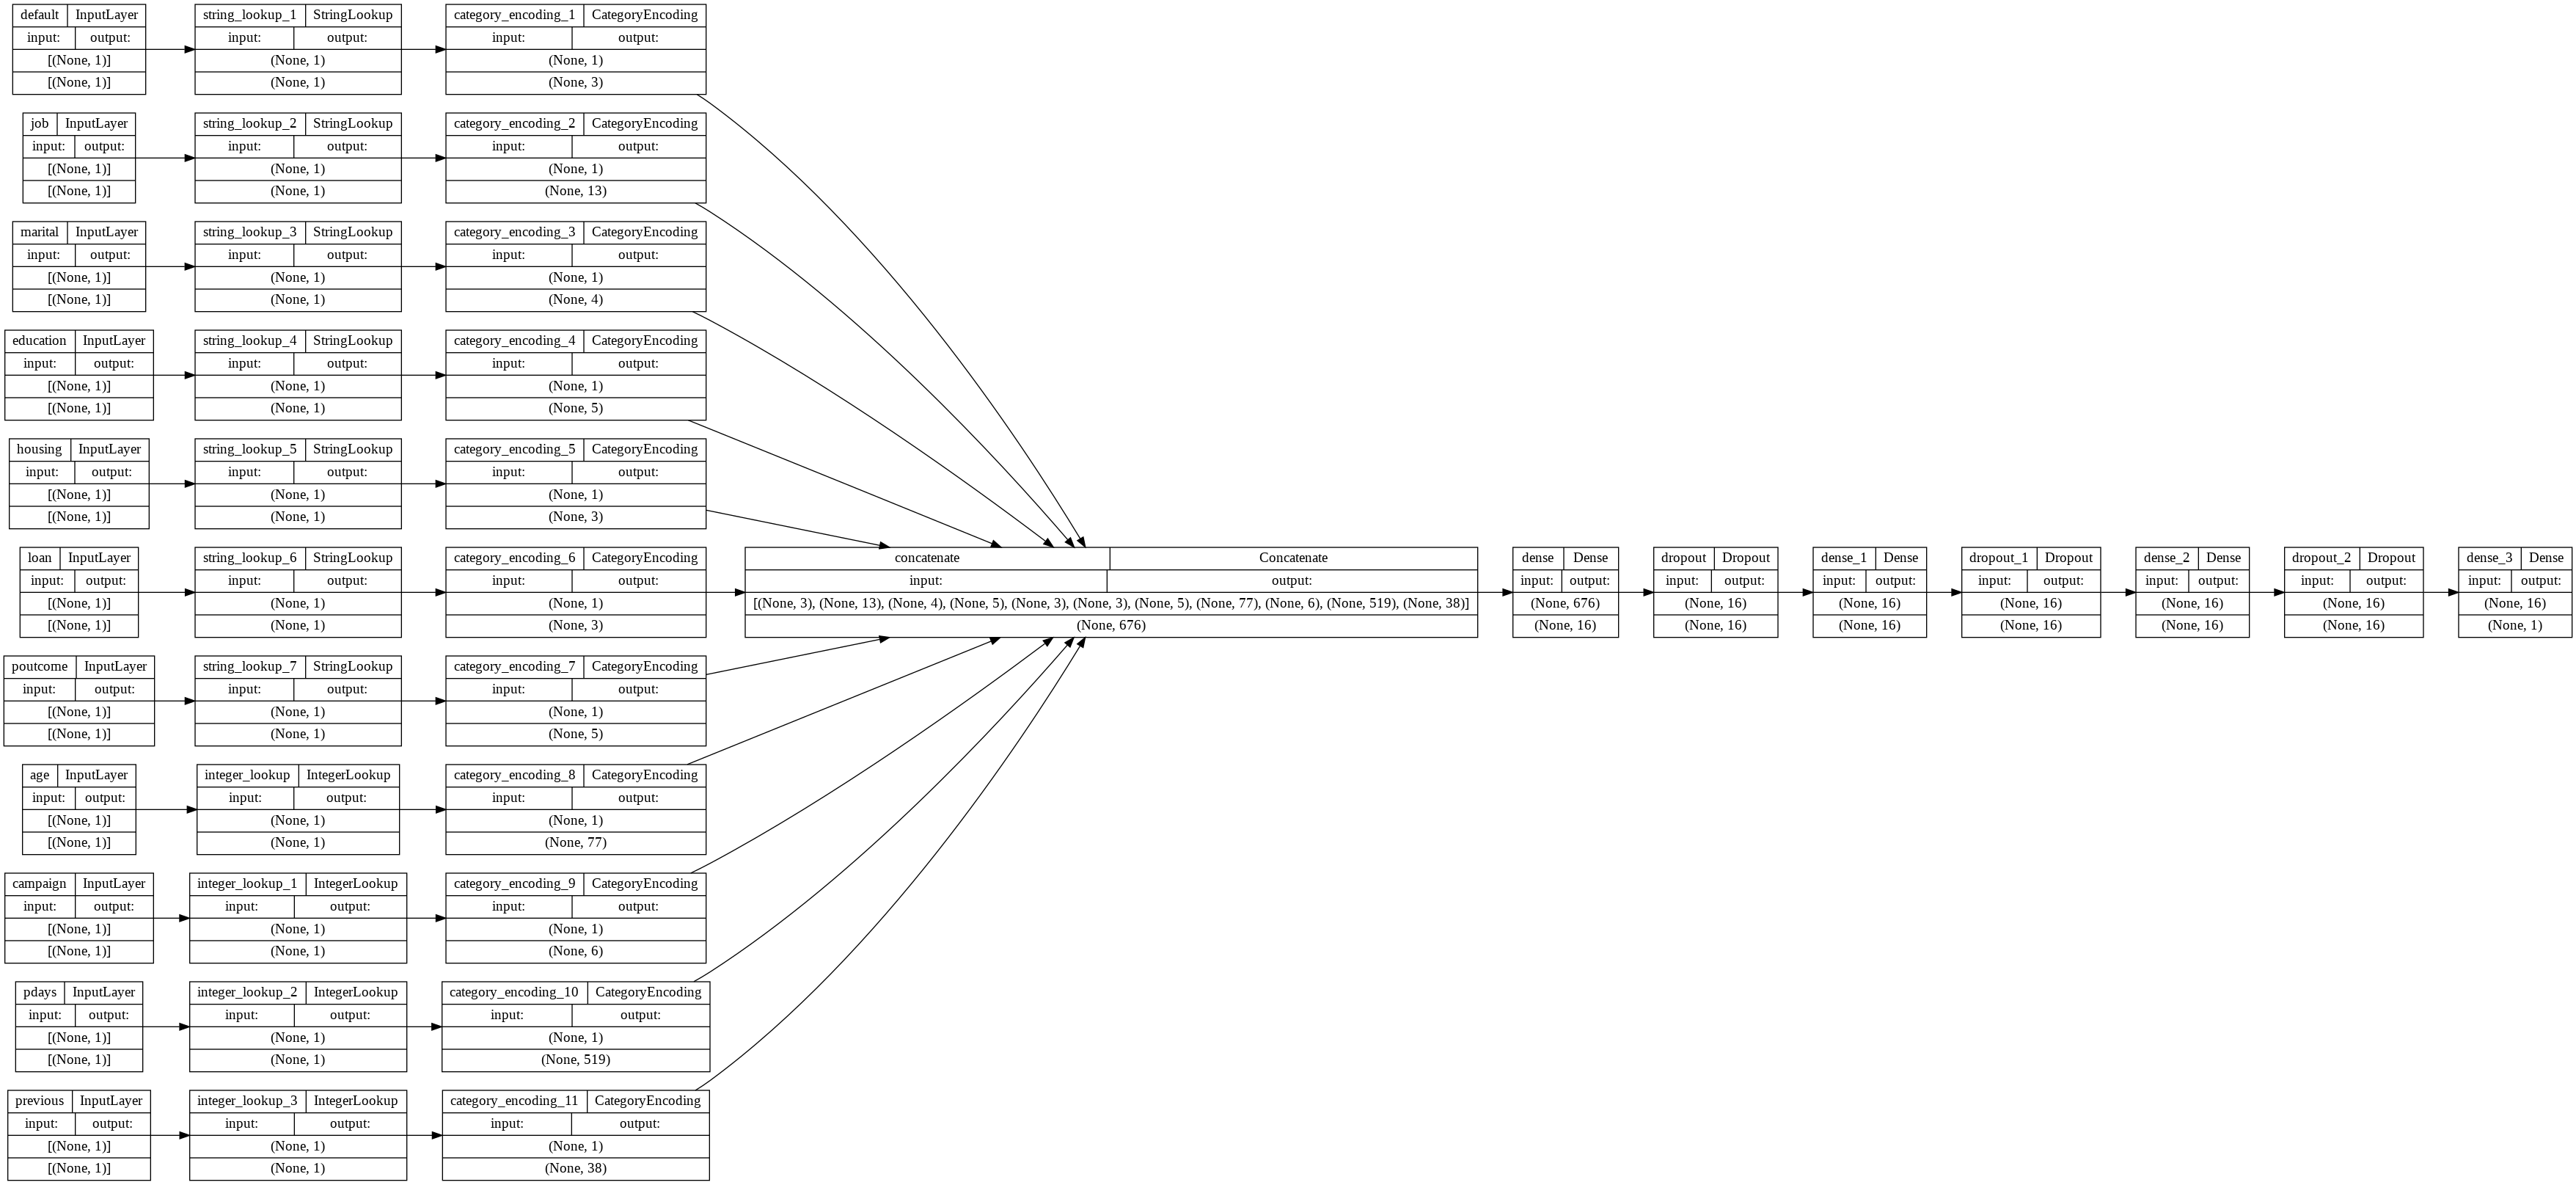

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]
model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(train_ds, epochs=100, validation_data=val_ds, validation_steps=32, callbacks=[loss, val_loss], steps_per_epoch=32)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['balance'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/32 [==============================] - 19s 419ms/step - loss: 0.6935 - tp: 10043.0000 - fp: 9919.0000 - tn: 6524.0000 - fn: 6282.0000 - accuracy: 0.5056 - precision: 0.5031 - recall: 0.6152 - auc: 0.5123 - val_loss: 0.6900 - val_tp: 10433.0000 - val_fp: 6975.0000 - val_tn: 9488.0000 - val_fn: 5872.0000 - val_accuracy: 0.6079 - val_precision: 0.5993 - val_recall: 0.6399 - val_auc: 0.6431
Epoch 2/100
32/32 [==============================] - 12s 394ms/step - loss: 0.6877 - tp: 8413.0000 - fp: 7590.0000 - tn: 8915.0000 - fn: 7850.0000 - accuracy: 0.5288 - precision: 0.5257 - recall: 0.5173 - auc: 0.5536 - val_loss: 0.6757 - val_tp: 8480.0000 - val_fp: 3418.0000 - val_tn: 12972.0000 - val_fn: 7898.0000 - val_accuracy: 0.6547 - val_precision: 0.7127 - val_recall: 0.5178 - val_auc: 0.7145
Epoch 3/100
32/32 [==============================] - 12s 402ms/step - loss: 0.6738 - tp: 9573.0000 - fp: 7331.0000 - tn: 9065.0000 - fn: 6799.0000 - accuracy: 0.5688 - precision: 0.5663 - recall: 0.5847 - 

##Model Evaluation

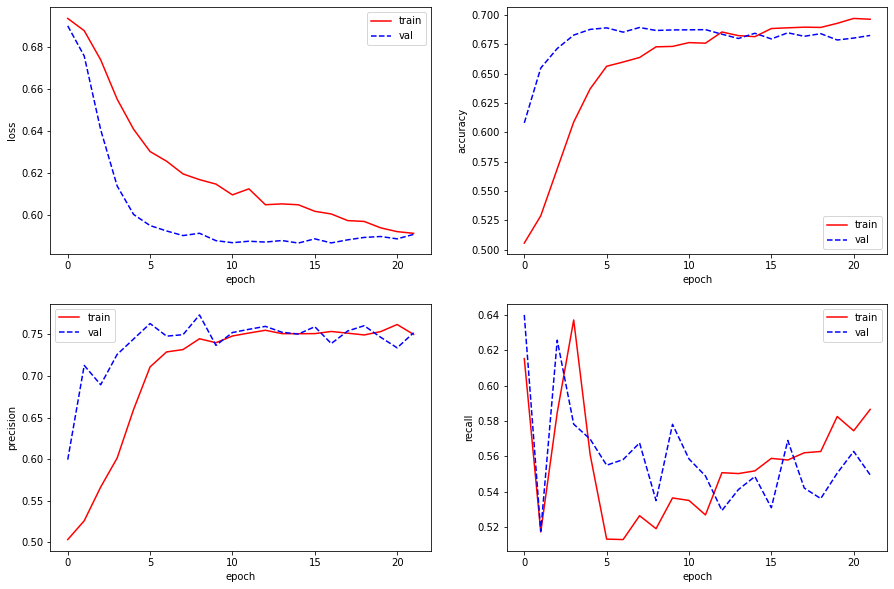

In [ ]:
metric = ['loss', 'accuracy', 'precision', 'recall']
plot_metric(2,2, history, metric)

In [ ]:
predict_test = model.predict(test_ds)
test_ds_unbach = test_ds.unbatch()
label_test = [i[1] for i in list(test_ds_unbach.as_numpy_iterator())]

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['balance'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


5/5 [==============================] - 0s 14ms/step - loss: 0.5733 - tp: 284.0000 - fp: 753.0000 - tn: 3247.0000 - fn: 237.0000 - accuracy: 0.7810 - precision: 0.2739 - recall: 0.5451 - auc: 0.7374
loss :  0.5732561945915222
tp :  284.0
fp :  753.0
tn :  3247.0
fn :  237.0
accuracy :  0.7810218930244446
precision :  0.2738669216632843
recall :  0.5451055765151978
auc :  0.7373989224433899
Legitimate Transactions Detected (True Negatives):  3247
Legitimate Transactions Incorrectly Detected (False Positives):  753
Fraudulent Transactions Missed (False Negatives):  237
Fraudulent Transactions Detected (True Positives):  284
Total Fraudulent Transactions:  521


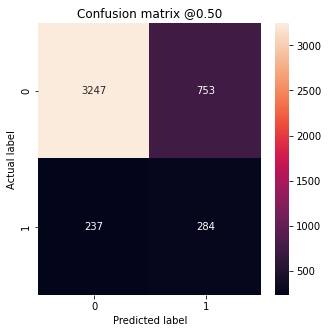

In [ ]:
model_evaluate = model.evaluate(test_ds)
for name_metric, value_evaluate in zip(model.metrics_names, model_evaluate):
  print(name_metric, ': ', value_evaluate)

plot_confution_matrix(label_test, predict_test)

Legitimate Transactions Detected (True Negatives):  529
Legitimate Transactions Incorrectly Detected (False Positives):  3471
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  502
Total Fraudulent Transactions:  521


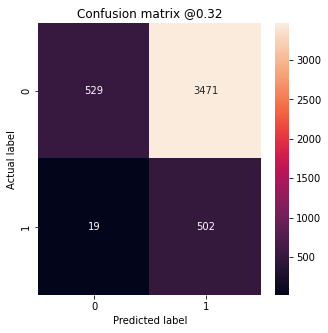

In [ ]:
plot_confution_matrix(label_test, predict_test, p=0.32)

Dari 4521 pelanggan, 529 nya berhasil diprediksi tidak akan berlangganan. Dengan begitu, dengan menggunakan model ini kita dapat mengurangi jumlah kampanye sebesar 11% (karena tim marketing tidak perlu mendatangi 529 orang tsb).

Dari 512 pelanggan yang sebenarnya berlangganan, 19 nya diprediksi tidak akan berlangganan. Dengan begitu, bank kehilangan sekitar 4% pelanggan.
.

In [ ]:
dataset_test.sort_values(by=["target"], ascending=True).head()

,age,job,marital,education,default,balance,housing,loan,campaign,pdays,previous,poutcome,target
0,30,unemployed,married,primary,no,1787,no,no,1,-1,0,unknown,0
2906,34,management,single,tertiary,no,0,no,no,2,-1,0,unknown,0
2907,44,technician,married,tertiary,no,1707,no,no,3,-1,0,unknown,0
2908,35,technician,married,secondary,no,13658,yes,no,2,-1,0,unknown,0
2909,39,admin.,married,secondary,no,406,no,no,5,-1,0,unknown,0


##Simulation

In [ ]:
sample = {
    'age': 35,
    'job': 'technician',
    'marital': 'married',
    'education': 'secondary',
    'balance': 13658,
    'housing': 'yes',
    'loan': 'no',
    'default':'no',
    'campaign':2,
    'pdays':-1,
    'previous':0,
    'poutcome':'unknown'
}
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"Probabilitas untuk berlangganan deposito berjangka adalah {round(100 * predictions[0][0], 2)} % "
    f"untuk setuju"
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['balance'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Probabilitas untuk berlangganan deposito berjangka adalah 35.74 % untuk setuju


##Kesimpulan
Dengan menggunakan model ini, bank dapat mengurangi beban pemasaran meskipun ada sedikit kerugian (karena ada potensi pelanggan yang benar-benar berlangganan salah diprediksi menjadi tidak berlangganan). Untuk pengembangan kedepannya, model ini masih dapat ditingkatkan supaya bisa semakin membantu pemasaran untuk bisa melakukan kampanye lebih efektif lagi.